# 3D brownian Motion as a classification problem

Create simulation

In [2]:
from tqdm import tqdm
from pygsig.datasets.brownian import Simulation3D

simulation =   Simulation3D(num_nodes= 300,
            num_blocks=3,
            p_across_blocks=0.05,
            p_within_blocks=0.1,
            mu_gain= 1,
            beta_gain=4,
            sigma_gain=1.0,
            omega_noise=0.0,
            time_horizon=10,
            task='classification',
            dt=1e-1)

gnn_dataset = []
base_seed = 0
num_runs = 1

with tqdm(total=num_runs) as pbar:
    for run in range(num_runs):
        simulation.run(graph_seed=run+base_seed,omega_seed=run+base_seed,param_seed=run+base_seed)
        seq = simulation.get_sequence()
        gnn_dataset.append(seq)
        pbar.update(1)

100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


## Signature encoder

Signature depth: 4


100%|██████████| 1/1 [00:00<00:00, 29.04it/s]


Name: GCNClassification
Number of parameters: 103875
Number of layers: 3
Signature depth: 4
Splits: 5, Trials: 4, Runs: 1, Epochs: 1000


100%|██████████| 20/20 [01:51<00:00,  5.59s/it]

Accuracy: 0.7792 ± 0.0879, Recall: 0.7792 ± 0.0879, Precision: 0.7792 ± 0.0879, F1: 0.7792 ± 0.0879


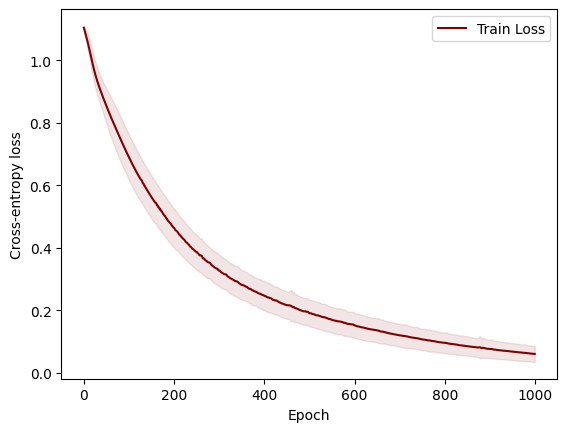

In [2]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from signatory import signature_channels
from pygsig.signature import SignatureFeatures


import pygsig.graph 
import pygsig.models
import pygsig.signature
from pygsig.models import GCNClassification,MLPClassification
from pygsig.graph import  split_nodes

import importlib
importlib.reload(pygsig.models)
importlib.reload(pygsig.signature)
importlib.reload(pygsig.graph)

num_nodes = gnn_dataset[0].num_nodes
dim = gnn_dataset[0].num_node_features
out_channels = gnn_dataset[0].y.shape[1]
num_splits = 3 # split the nodes
num_runs = len(gnn_dataset)
num_trials = 4
num_epochs = 1000

# hyperparameters
learning_rate = 1e-3
lasso = 0
num_hidden = 64

print_during_training = False

# create models 
min_depth = 4
max_depth = 4
min_hidden_layers = 2
max_hidden_layers = 2

for depth in range(min_depth,max_depth+1):
    print(f'Signature depth: {depth}')
    dataset = []
    for seq in tqdm(gnn_dataset):
        signature_transform = SignatureFeatures(sig_depth=depth, normalize=True, log_signature=False,lead_lag=True)
        dataset.append(signature_transform(seq))

    for num_layers in range(min_hidden_layers,max_hidden_layers+1):
        in_channels = signature_channels(2*dim,depth)
        model = GCNClassification(num_channels=[in_channels]+num_layers*[num_hidden]+[out_channels])
        num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f'Name: {model._get_name()}')
        print(f"Number of parameters: {num_params}")
        print(f"Number of layers: {num_layers+1}")
        print(f"Signature depth: {depth}")
        print(f"Splits: {num_splits}, Trials: {num_trials}, Runs: {num_runs}, Epochs: {num_epochs}")
        
        #loss function
        criterion = nn.CrossEntropyLoss()
        
        # optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=lasso) 

        train_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs]) 
        eval_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs])
        accuracy = np.zeros([num_splits, num_runs, num_trials])
        recall = np.zeros([num_splits, num_runs, num_trials])
        precision = np.zeros([num_splits, num_runs, num_trials])
        f1 = np.zeros([num_splits, num_runs, num_trials])
        confusion = np.zeros([num_splits, num_runs, num_trials,out_channels,out_channels])

        with tqdm(total=num_splits*num_runs*num_trials, disable=print_during_training) as pbar:
            # all splits into training/eval and testing data
            splits = split_nodes(num_nodes, num_splits,test_ratio=1.0,seed=29)
            for split in range(num_splits):
                # split the nodes 
                train_indices, eval_indices, test_indices = splits[split]
                train_mask = torch.zeros(num_nodes, dtype=torch.bool)
                eval_mask = torch.zeros(num_nodes, dtype=torch.bool)
                test_mask = torch.zeros(num_nodes, dtype=torch.bool)
                train_mask[train_indices] = True
                eval_mask[eval_indices] = True
                test_mask[test_indices] = True
                # train the model from scratch on each simulation (run)  for several different initializations (trail)
                for run, data in enumerate(dataset):
                    for trial in range(num_trials):
                        model.reset_parameters()
                        for epoch in range(num_epochs):
                            # train
                            model.train()
                            optimizer.zero_grad()
                            out = model(data.x, data.edge_index)
                            train_loss = criterion(out[train_mask], data.y[train_mask])
                            train_loss.backward()
                            optimizer.step()
                            # evaluate
                            model.eval()
                            with torch.no_grad():
                                eval_loss = criterion(out[eval_mask], data.y[eval_mask])
                                train_losses[split, run, trial, epoch] = train_loss.item()
                                eval_losses[split, run, trial, epoch] = eval_loss.item()
                            if epoch % 10 == 0 and print_during_training:
                                print(f'Split {split}, Run {run}, Trial {trial}, Epoch {epoch}, Train Loss: {train_loss.item():.4f}')
                        pbar.update(1)
                        # compute the errors on the testing loss after the last epoch
                        with torch.no_grad():
                            out = model(data.x, data.edge_index)
                            accuracy[split,run,trial] = accuracy_score(data.y[test_mask].argmax(dim=1).numpy(), out[test_mask].argmax(dim=1).numpy())
                            recall[split,run,trial] = recall_score(data.y[test_mask].argmax(dim=1).numpy(), out[test_mask].argmax(dim=1).numpy(),average='micro')
                            precision[split,run,trial] = precision_score(data.y[test_mask].argmax(dim=1).numpy(), out[test_mask].argmax(dim=1).numpy(),average='micro')
                            f1[split,run,trial] = f1_score(data.y[test_mask].argmax(dim=1).numpy(), out[test_mask].argmax(dim=1).numpy(),average='micro')
                            confusion[split,run,trial] = confusion_matrix(data.y[test_mask].argmax(dim=1).numpy(), out[test_mask].argmax(dim=1).numpy())
        print(f'Accuracy: {np.mean(accuracy):.4f} ± {np.std(accuracy):.4f}, Recall: {np.mean(recall):.4f} ± {np.std(recall):.4f}, Precision: {np.mean(precision):.4f} ± {np.std(precision):.4f}, F1: {np.mean(f1):.4f} ± {np.std(f1):.4f}')

        # Plotting
        avg_train_losses = np.mean(train_losses, axis=(0,1,2))
        std_train_losses = np.std(train_losses, axis=(0,1,2))
        
        plt.figure()
        plt.plot(avg_train_losses,  label='Train Loss', color='maroon')
        plt.fill_between(range(num_epochs), avg_train_losses - std_train_losses, avg_train_losses + std_train_losses, alpha=0.1, color='maroon')
        plt.xlabel('Epoch')
        plt.ylabel('Cross-entropy loss')
        plt.legend()
        plt.show()

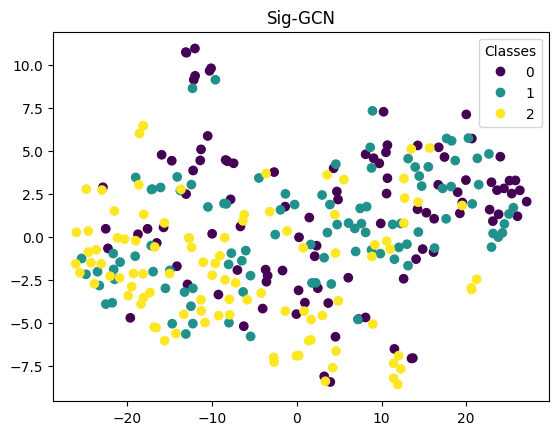

In [3]:
from sklearn.manifold import TSNE

latent_variables = model.conv[0](data.x,data.edge_index)

tsne = TSNE(n_components=2,perplexity=30,random_state=30)
X_embedded = tsne.fit_transform(latent_variables.detach().numpy())

plt.figure()
scatter = plt.scatter(X_embedded[:,0],X_embedded[:,1],c=data.y.argmax(dim=1).numpy())
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title('Sig-GCN')
plt.show()

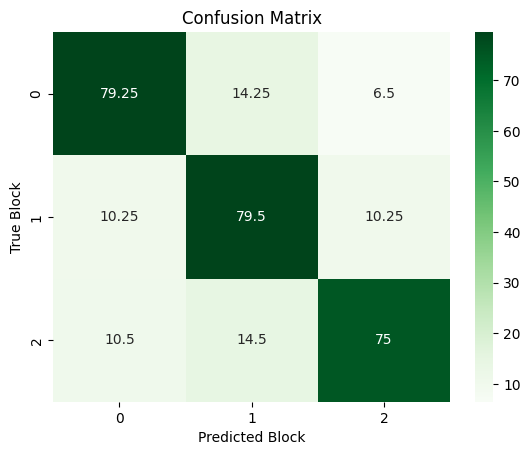

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion.sum(axis=0).mean(axis=(0,1))
plt.figure()
plt.title('Confusion Matrix')
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens')
plt.xlabel('Predicted Block')
plt.ylabel('True Block')
plt.show()

## TS2Vec encoder

### Train encoder

Create training data for encoder

In [12]:
from tqdm import tqdm

simulation =   Simulation3D(num_nodes= 300,
            num_blocks=3,
            p_across_blocks=0.05,
            p_within_blocks=0.1,
            mu_gain= 1,
            beta_gain=4,
            sigma_gain=1.0,
            omega_noise=0.0,
            time_horizon=10,
            task='classification',
            dt=1e-1)

base_seed = 29
enc_dataset = []
num_runs = 10

with tqdm(total=num_runs) as pbar:
    for run in range(num_runs):
        simulation.run(graph_seed=run+base_seed,omega_seed=run+base_seed,param_seed=run+base_seed)
        seq = simulation.get_sequence()
        enc_dataset.append(seq)
        pbar.update(1)

100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


Train the encoder

In [15]:
import signatory
from ts2vec.ts2vec import TS2Vec
import signatory
import torch

X_train = torch.stack([torch.stack([snapshot.x for snapshot in seq]) for seq in enc_dataset]).view(-1,enc_dataset[0].snapshot_count,3).numpy()

dim = enc_dataset[0].num_node_features

encoder = TS2Vec(
    input_dims=3,
    device='cpu',
    hidden_dims=64,
    output_dims=signatory.signature_channels(2*dim,4),
    batch_size=32,
)


loss_log = encoder.fit(
    X_train,
    verbose=True,
)

torch.save(encoder,'encoders/brownian/TS2Vec-3D.pt')

Epoch #0: loss=69.77403552045104
Epoch #1: loss=3.490183937934137
Epoch #2: loss=2.822698793103618
Epoch #3: loss=2.5224716099359656
Epoch #4: loss=2.449715880937474
Epoch #5: loss=2.2738166009226153


### GNN with TS2Vec encoder

In [21]:
import torch
from torch_geometric.data import Data
from tqdm import tqdm
from pygsig.transforms import TS2VecFeatures

encoder = torch.load('encoders/brownian/TS2Vec-3D.pt')
ts2vec = TS2VecFeatures(encoder)
dataset = []

dataset = []
for seq in tqdm(gnn_dataset):
    dataset.append(ts2vec(seq))

100%|██████████| 1/1 [00:04<00:00,  4.07s/it]


Name: GCNClassification
Number of parameters: 103875
Number of layers: 3
Signature depth: 4
Splits: 5, Trials: 4, Runs: 1, Epochs: 400


100%|██████████| 20/20 [01:07<00:00,  3.37s/it]

Accuracy: 0.6267 ± 0.0631, Recall: 0.6267 ± 0.0631, Precision: 0.6267 ± 0.0631, F1: 0.6267 ± 0.0631


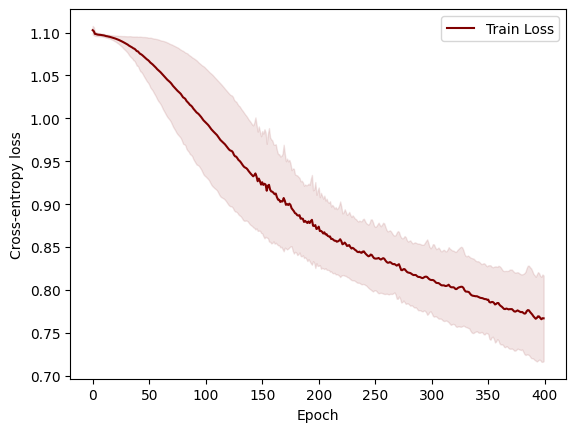

In [23]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from signatory import signature_channels
from pygsig.signature import SignatureFeatures


import pygsig.graph 
import pygsig.models
import pygsig.signature
from pygsig.models import GCNClassification,MLPClassification
from pygsig.graph import  split_nodes

import importlib
importlib.reload(pygsig.models)
importlib.reload(pygsig.signature)
importlib.reload(pygsig.graph)

num_nodes = gnn_dataset[0].num_nodes
dim = gnn_dataset[0].num_node_features
out_channels = gnn_dataset[0].y.shape[1]
num_splits = 5 # split the nodes
num_runs = len(gnn_dataset)
num_trials = 4
num_epochs = 400

# hyperparameters
learning_rate = 1e-3
lasso = 0
num_hidden = 64

print_during_training = False

# create models 
min_hidden_layers = 2
max_hidden_layers = 2

for num_layers in range(min_hidden_layers,max_hidden_layers+1):
    in_channels = signature_channels(2*dim,depth)
    model = GCNClassification(num_channels=[in_channels]+num_layers*[num_hidden]+[out_channels])
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Name: {model._get_name()}')
    print(f"Number of parameters: {num_params}")
    print(f"Number of layers: {num_layers+1}")
    print(f"Signature depth: {depth}")
    print(f"Splits: {num_splits}, Trials: {num_trials}, Runs: {num_runs}, Epochs: {num_epochs}")
    
    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=lasso) 
    train_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs]) 
    eval_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs])
    accuracy = np.zeros([num_splits, num_runs, num_trials])
    recall = np.zeros([num_splits, num_runs, num_trials])
    precision = np.zeros([num_splits, num_runs, num_trials])
    f1 = np.zeros([num_splits, num_runs, num_trials])
    confusion = np.zeros([num_splits, num_runs, num_trials,out_channels,out_channels])

    with tqdm(total=num_splits*num_runs*num_trials, disable=print_during_training) as pbar:
        splits = split_nodes(num_nodes, num_splits,test_ratio=1.0,seed=29)
        for split in range(num_splits):
            train_indices, eval_indices, test_indices = splits[split]
            train_mask = torch.zeros(num_nodes, dtype=torch.bool)
            eval_mask = torch.zeros(num_nodes, dtype=torch.bool)
            test_mask = torch.zeros(num_nodes, dtype=torch.bool)
            train_mask[train_indices] = True
            eval_mask[eval_indices] = True
            test_mask[test_indices] = True
            for run, data in enumerate(dataset):
                for trial in range(num_trials):
                    model.reset_parameters()
                    for epoch in range(num_epochs):
                        # train
                        model.train()
                        optimizer.zero_grad()
                        out = model(data.x, data.edge_index)
                        train_loss = criterion(out[train_mask], data.y[train_mask])
                        train_loss.backward()
                        optimizer.step()
                        # evaluate
                        model.eval()
                        with torch.no_grad():
                            eval_loss = criterion(out[eval_mask], data.y[eval_mask])
                            train_losses[split, run, trial, epoch] = train_loss.item()
                            eval_losses[split, run, trial, epoch] = eval_loss.item()
                        if epoch % 10 == 0 and print_during_training:
                            print(f'Split {split}, Run {run}, Trial {trial}, Epoch {epoch}, Train MSE Loss: {train_loss.item():.4f}, Evaulation MSE Loss: {eval_loss.item():.4f}')
                    pbar.update(1)
                    # compute the errors on the testing loss after the last epoch
                    with torch.no_grad():
                        out = model(data.x, data.edge_index)
                        accuracy[split,run,trial] = accuracy_score(data.y[test_mask].argmax(dim=1).numpy(), out[test_mask].argmax(dim=1).numpy())
                        recall[split,run,trial] = recall_score(data.y[test_mask].argmax(dim=1).numpy(), out[test_mask].argmax(dim=1).numpy(),average='micro')
                        precision[split,run,trial] = precision_score(data.y[test_mask].argmax(dim=1).numpy(), out[test_mask].argmax(dim=1).numpy(),average='micro')
                        f1[split,run,trial] = f1_score(data.y[test_mask].argmax(dim=1).numpy(), out[test_mask].argmax(dim=1).numpy(),average='micro')
                        confusion[split,run,trial] = confusion_matrix(data.y[test_mask].argmax(dim=1).numpy(), out[test_mask].argmax(dim=1).numpy())

    print(f'Accuracy: {np.mean(accuracy):.4f} ± {np.std(accuracy):.4f}, Recall: {np.mean(recall):.4f} ± {np.std(recall):.4f}, Precision: {np.mean(precision):.4f} ± {np.std(precision):.4f}, F1: {np.mean(f1):.4f} ± {np.std(f1):.4f}')

    # Plotting
    avg_train_losses = np.mean(train_losses, axis=(0,1,2))
    std_train_losses = np.std(train_losses, axis=(0,1,2))
    
    plt.figure()
    plt.plot(avg_train_losses,  label='Train Loss', color='maroon')
    plt.fill_between(range(num_epochs), avg_train_losses - std_train_losses, avg_train_losses + std_train_losses, alpha=0.1, color='maroon')
    plt.xlabel('Epoch')
    plt.ylabel('Cross-entropy loss')
    plt.legend()
    plt.show()

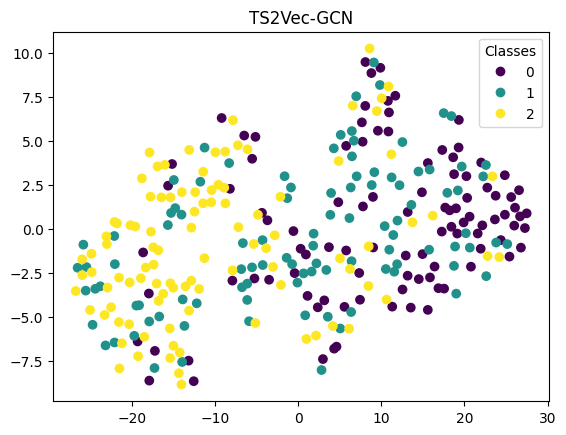

In [24]:
from sklearn.manifold import TSNE

latent_variables = model.conv[0](data.x, data.edge_index)

tsne = TSNE(n_components=2, perplexity=30, random_state=29)
X_embedded = tsne.fit_transform(latent_variables.detach().numpy())

plt.figure()
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=data.y.argmax(dim=1).numpy(), cmap='viridis')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title('TS2Vec-GCN')
plt.show()

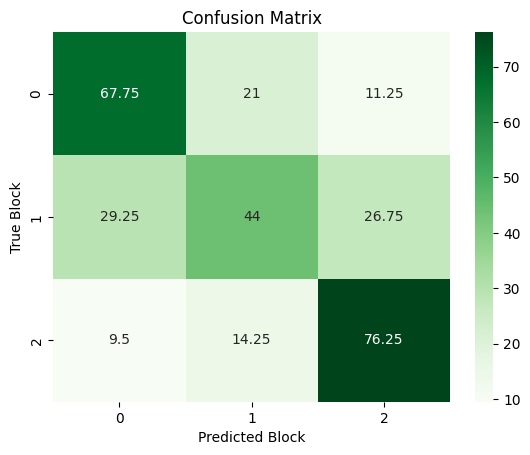

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion.sum(axis=0).mean(axis=(0,1))
plt.figure()
plt.title('Confusion Matrix')
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens')
plt.xlabel('Predicted Block')
plt.ylabel('True Block')
plt.show()

# Random encoder (baseline)

In [27]:
import torch
from tqdm import tqdm
from pygsig.transforms import RandomFeatures
import signatory

rand_encode = RandomFeatures(num_features=signatory.signature_channels(2*dim,4))
dataset = []

dataset = []
for seq in tqdm(gnn_dataset):
    dataset.append(rand_encode(seq))

100%|██████████| 1/1 [00:00<00:00, 89.06it/s]


Name: GCNClassification
Number of parameters: 103875
Number of layers: 3
Signature depth: 4
Splits: 5, Trials: 4, Runs: 1, Epochs: 400


100%|██████████| 20/20 [00:59<00:00,  2.96s/it]

Accuracy: 0.8408 ± 0.0496, Recall: 0.8408 ± 0.0496, Precision: 0.8408 ± 0.0496, F1: 0.8408 ± 0.0496


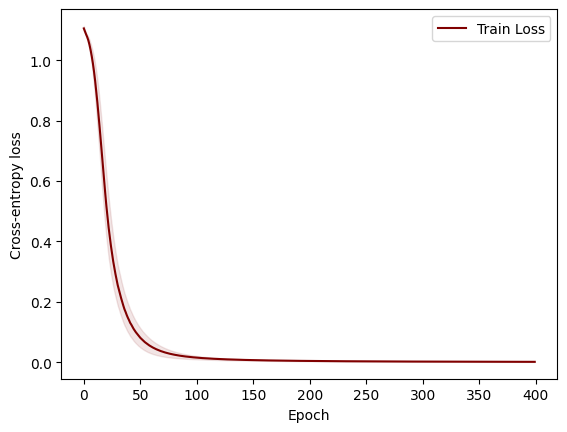

In [28]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from signatory import signature_channels
from pygsig.signature import SignatureFeatures


import pygsig.graph 
import pygsig.models
import pygsig.signature
from pygsig.models import GCNClassification,MLPClassification
from pygsig.graph import  split_nodes

import importlib
importlib.reload(pygsig.models)
importlib.reload(pygsig.signature)
importlib.reload(pygsig.graph)

num_nodes = gnn_dataset[0].num_nodes
dim = gnn_dataset[0].num_node_features
out_channels = gnn_dataset[0].y.shape[1]
num_splits = 5 # split the nodes
num_runs = len(gnn_dataset)
num_trials = 4
num_epochs = 400

# hyperparameters
learning_rate = 1e-3
lasso = 0
num_hidden = 64

print_during_training = False

# create models 
min_hidden_layers = 2
max_hidden_layers = 2

for num_layers in range(min_hidden_layers,max_hidden_layers+1):
    in_channels = signature_channels(2*dim,depth)
    model = GCNClassification(num_channels=[in_channels]+num_layers*[num_hidden]+[out_channels])
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Name: {model._get_name()}')
    print(f"Number of parameters: {num_params}")
    print(f"Number of layers: {num_layers+1}")
    print(f"Signature depth: {depth}")
    print(f"Splits: {num_splits}, Trials: {num_trials}, Runs: {num_runs}, Epochs: {num_epochs}")
    
    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=lasso) 
    train_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs]) 
    eval_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs])
    accuracy = np.zeros([num_splits, num_runs, num_trials])
    recall = np.zeros([num_splits, num_runs, num_trials])
    precision = np.zeros([num_splits, num_runs, num_trials])
    f1 = np.zeros([num_splits, num_runs, num_trials])
    confusion = np.zeros([num_splits, num_runs, num_trials,out_channels,out_channels])

    with tqdm(total=num_splits*num_runs*num_trials, disable=print_during_training) as pbar:
        splits = split_nodes(num_nodes, num_splits,test_ratio=1.0,seed=29)
        for split in range(num_splits):
            train_indices, eval_indices, test_indices = splits[split]
            train_mask = torch.zeros(num_nodes, dtype=torch.bool)
            eval_mask = torch.zeros(num_nodes, dtype=torch.bool)
            test_mask = torch.zeros(num_nodes, dtype=torch.bool)
            train_mask[train_indices] = True
            eval_mask[eval_indices] = True
            test_mask[test_indices] = True
            for run, data in enumerate(dataset):
                for trial in range(num_trials):
                    model.reset_parameters()
                    for epoch in range(num_epochs):
                        # train
                        model.train()
                        optimizer.zero_grad()
                        out = model(data.x, data.edge_index)
                        train_loss = criterion(out[train_mask], data.y[train_mask])
                        train_loss.backward()
                        optimizer.step()
                        # evaluate
                        model.eval()
                        with torch.no_grad():
                            eval_loss = criterion(out[eval_mask], data.y[eval_mask])
                            train_losses[split, run, trial, epoch] = train_loss.item()
                            eval_losses[split, run, trial, epoch] = eval_loss.item()
                        if epoch % 10 == 0 and print_during_training:
                            print(f'Split {split}, Run {run}, Trial {trial}, Epoch {epoch}, Train MSE Loss: {train_loss.item():.4f}, Evaulation MSE Loss: {eval_loss.item():.4f}')
                    pbar.update(1)
                    # compute the errors on the testing loss after the last epoch
                    with torch.no_grad():
                        out = model(data.x, data.edge_index)
                        accuracy[split,run,trial] = accuracy_score(data.y[test_mask].argmax(dim=1).numpy(), out[test_mask].argmax(dim=1).numpy())
                        recall[split,run,trial] = recall_score(data.y[test_mask].argmax(dim=1).numpy(), out[test_mask].argmax(dim=1).numpy(),average='micro')
                        precision[split,run,trial] = precision_score(data.y[test_mask].argmax(dim=1).numpy(), out[test_mask].argmax(dim=1).numpy(),average='micro')
                        f1[split,run,trial] = f1_score(data.y[test_mask].argmax(dim=1).numpy(), out[test_mask].argmax(dim=1).numpy(),average='micro')
                        confusion[split,run,trial] = confusion_matrix(data.y[test_mask].argmax(dim=1).numpy(), out[test_mask].argmax(dim=1).numpy())

    print(f'Accuracy: {np.mean(accuracy):.4f} ± {np.std(accuracy):.4f}, Recall: {np.mean(recall):.4f} ± {np.std(recall):.4f}, Precision: {np.mean(precision):.4f} ± {np.std(precision):.4f}, F1: {np.mean(f1):.4f} ± {np.std(f1):.4f}')

    # Plotting
    avg_train_losses = np.mean(train_losses, axis=(0,1,2))
    std_train_losses = np.std(train_losses, axis=(0,1,2))
    
    plt.figure()
    plt.plot(avg_train_losses,  label='Train Loss', color='maroon')
    plt.fill_between(range(num_epochs), avg_train_losses - std_train_losses, avg_train_losses + std_train_losses, alpha=0.1, color='maroon')
    plt.xlabel('Epoch')
    plt.ylabel('Cross-entropy loss')
    plt.legend()
    plt.show()

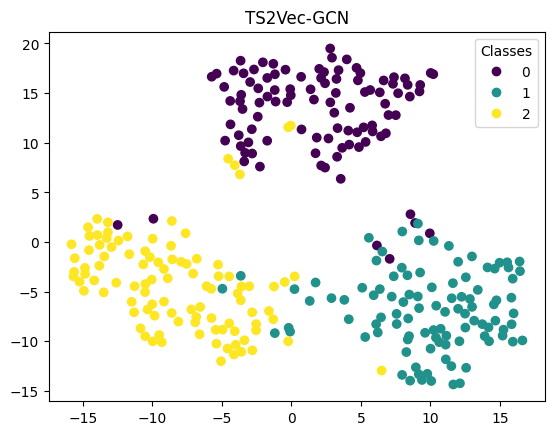

In [29]:
from sklearn.manifold import TSNE

latent_variables = model.conv[0](data.x, data.edge_index)

tsne = TSNE(n_components=2, perplexity=30, random_state=29)
X_embedded = tsne.fit_transform(latent_variables.detach().numpy())

plt.figure()
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=data.y.argmax(dim=1).numpy(), cmap='viridis')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title('TS2Vec-GCN')
plt.show()

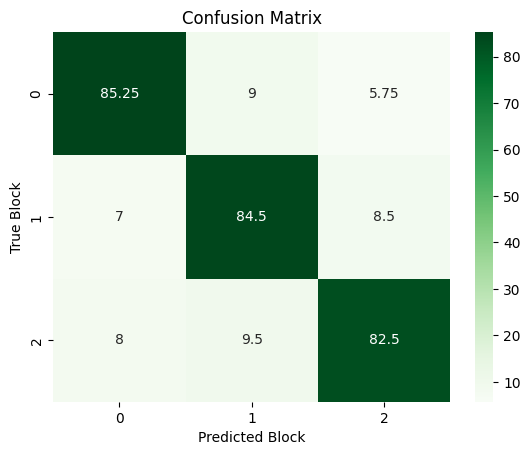

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion.sum(axis=0).mean(axis=(0,1))
plt.figure()
plt.title('Confusion Matrix')
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens')
plt.xlabel('Predicted Block')
plt.ylabel('True Block')
plt.show()